In [1]:
import torch
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

from torchvision.transforms.functional import to_pil_image, to_tensor, normalize, resize
from torchvision.transforms.v2.functional import grayscale_to_rgb
from datasets import load_dataset, Image

from torch import nn
from torch.utils.data import DataLoader

from model import ViT, ConvStem
from train import train_model

In [2]:
ds = load_dataset("uoft-cs/cifar10").shuffle()

In [3]:
def transforms(obj: dict):
        obj['img'] = [to_tensor(resize(img, (64, 64))) if to_tensor(img).shape[0] == 3 else to_tensor(grayscale_to_rgb(resize(img, (64, 64)))) for img in obj['img']]
        return obj
    
ds.set_transform(transforms)

In [4]:
model = ViT(num_layers=12, num_classes=10, emb_dim=768, ffn_dim=768*3, attn_heads=12, patch_size=16, batch_size=128, attn_dropout=0.0, ffn_dropout=0.0).cuda()

In [5]:
model.apply(model.init_weights)

ViT(
  (patch_emb): ConvStem(
    (conv_layers): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
      (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(4, 4), padding=(1, 1), bias=False)
      (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): ReLU()
    )
    (proj): Linear(in_features=128, out_features=768, bias=False)
  )
  (transformer_enc): Sequential(
    (0): ViTBlock(
      (attn): MultiheadAttnBlock(
        (attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (ln): LayerNorm((768,), eps=

In [6]:
sum([p.numel() for p in model.parameters()])

78149162

In [7]:
train_dl = DataLoader(ds['train'], batch_size=128, shuffle=True, drop_last=True)
test_dl = DataLoader(ds['test'], batch_size=128, shuffle=False, drop_last=True)

In [8]:
criterion = torch.nn.CrossEntropyLoss()

In [9]:
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-4)

In [10]:
train_model(model, optimizer, criterion, train_dl, test_dl, 50)

c:\Users\Илья\AppData\Local\Programs\Python\Python311\Lib\site-packages\neptune\common\warnings.py:71: NeptuneWarning: The following monitoring options are disabled by default in interactive sessions: 'capture_stdout', 'capture_stderr', 'capture_traceback', and 'capture_hardware_metrics'. To enable them, set each parameter to 'True' when initializing the run. The monitoring will continue until you call run.stop() or the kernel stops. Also note: Your source files can only be tracked if you pass the path(s) to the 'source_code' argument. For help, see the Neptune docs: https://docs.neptune.ai/logging/source_code/
  warnings.warn(


https://app.neptune.ai/bng215/Model-Collapse/e/TRAN-806


Epoch: 1: Train stage:   0%|          | 0/390 [00:00<?, ?it/s]c:\Users\Илья\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\functional.py:5504: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = scaled_dot_product_attention(q, k, v, attn_mask, dropout_p, is_causal)
Epoch: 26: Train stage:   2%|▏         | 7/390 [00:00<00:37, 10.17it/s]


KeyboardInterrupt: 

In [11]:
custom_f1 = pd.read_csv('results/custom_f1.csv', header=None)[2]
custom_test_loss = pd.read_csv('results/custom_test_loss.csv', header=None)[2]
custom_train_loss = pd.read_csv('results/custom_train_loss.csv', header=None)[2]

hf_f1 = pd.read_csv('results/hf_f1.csv', header=None)[2]
hf_test_loss = pd.read_csv('results/hf_test_loss.csv', header=None)[2]
hf_train_loss = pd.read_csv('results/hf_train_loss.csv', header=None)[2]

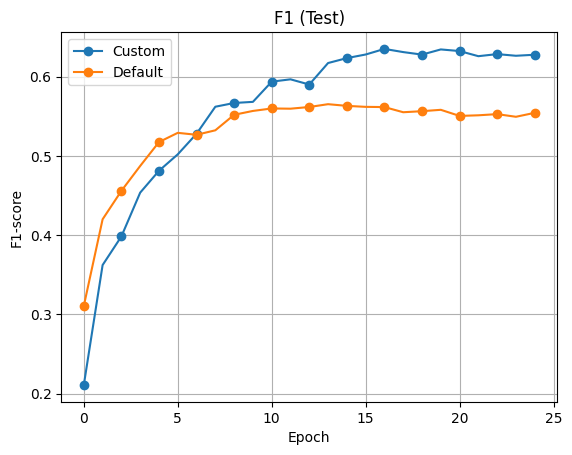

In [12]:
plt.title('F1 (Test)')
plt.ylabel("F1-score")
plt.xlabel("Epoch")
plt.grid(True)
plt.plot(custom_f1, label='Custom', marker='o', markevery=2)
plt.plot(hf_f1, label='Default', marker='o', markevery=2)
plt.legend()
plt.show()

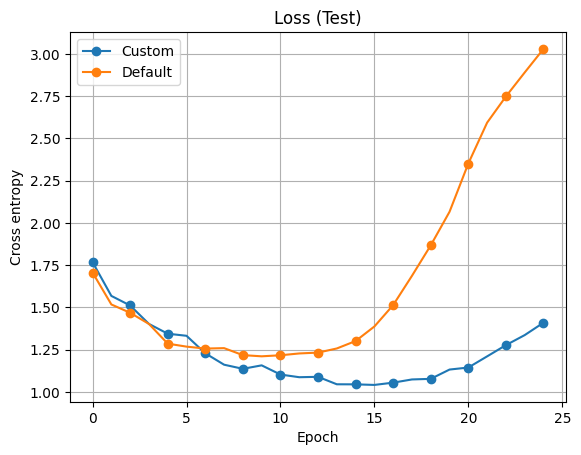

In [13]:
plt.title('Loss (Test)')
plt.ylabel("Cross entropy")
plt.xlabel("Epoch")
plt.grid(True)
plt.plot(custom_test_loss, label='Custom', marker='o', markevery=2)
plt.plot(hf_test_loss, label='Default', marker='o', markevery=2)
plt.legend()
plt.show()

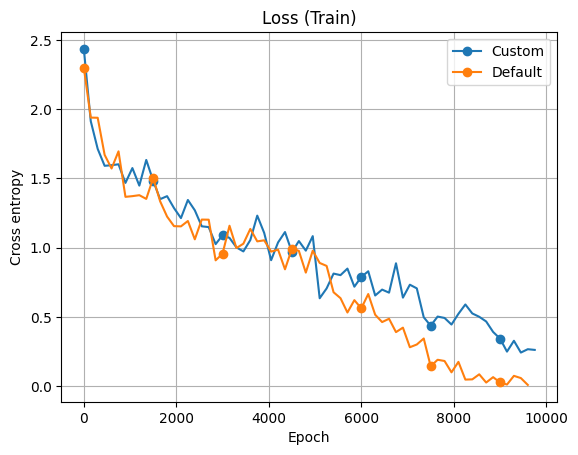

In [14]:
plt.title('Loss (Train)')
plt.ylabel("Cross entropy")
plt.xlabel("Epoch")
plt.grid(True)
plt.plot(custom_train_loss[::150], label='Custom', marker='o', markevery=10)
plt.plot(hf_train_loss[::150], label='Default', marker='o', markevery=10)
plt.legend()
plt.show()